# Polyalphabetische Verschlüsselung

Folgender Text wurde mittels einer Vigènereverschlüsselung chiffriert:

`PIXRVKPMVPAGBLPMELZXEIVOEGCAPRPIXIIUDXUKQBBLXQKKFTFOZYEBHBLQADXYRQRXZGTRXPFIEBZIMUVOODYIASSR
 TMMQUGKODYIASMNTSCEEFVHQRGLVQSVOVQIUDIUSXHYOHDYCBTTUEXYLLYZTXYXQIELRPIXZIQIGAIULNUKQNMDMOKXS
 XQDXYVGSLPWOHTTIDIDHRUSVOIWRRWXALHNIIIESMMMYYMQDFHRQNWLHQSXYWFEGDIXTDYMQGXZZANBOQETTTQQNLVAA
 HEKMQBXNVUFYZHQFBUMFIHUIZWBLEGCAKMQAUNVQNSBRSUGAIDEBUEZDXYHQMYVPSEGKFQSVOEQFMPKFSBJLPIXRVKPM
 VKDAIOMQMBAHQRXUXIIVRPGNZBRPAGDIZDNUKPEKLMZZXSRQNOLVRAAYIZUGKHUEDYCBTHHRMLRZIYIMKIDEGZXMEKRI
 ZUGKWOHPHIOHXUEZDXYWROKTYXIXYXNEYHWETLPGTDBLODYIASSRTWLUEFPXPEKZMOHXYLQIMKIDEBNIZEGNITEBTIZK
 HTQGNBREFIHUKQGXUYZBXMYSTXLRFZBMJQRNUKADXYZQRTLRPEKBRSWTLLDEGKHUEDYCBTHHRMLRZICUTZMMLLNISEGZ
 TUEELVUNWLVWRRWXAGKHTTIXKEEBKLGTEGKIDSBJLQRALMFDXYOAMFBRUKTAMANSBQLIXSLMTDYCBTHNVMPAPIGNWRVK
 PMVEZAEFWQWXYHQNWHLQRTBGTAEZHQFXUWUVXBRPOYMIZSBCIWRRWXALHNMQBXGIUCAUIF`

### Schlüssellänge

Zuerst möchten wir versuchen die Schlüssellänge $|K|$ mittels Autokorrelation zu bestimmen, um das Chiffrat zu partitionieren.

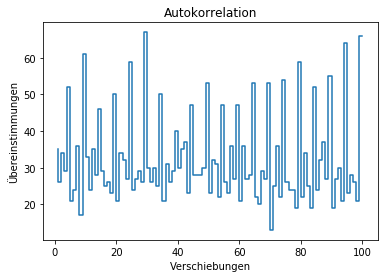

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

ciphertext = "PIXRVKPMVPAGBLPMELZXEIVOEGCAPRPIXIIUDXUKQBBLXQKKFTFOZYEBHBLQADXYRQRXZGTRXPFIEBZIMUVOODYIASSRTMMQUGKODYIASMNTSCEEFVHQRGLVQSVOVQIUDIUSXHYOHDYCBTTUEXYLLYZTXYXQIELRPIXZIQIGAIULNUKQNMDMOKXSXQDXYVGSLPWOHTTIDIDHRUSVOIWRRWXALHNIIIESMMMYYMQDFHRQNWLHQSXYWFEGDIXTDYMQGXZZANBOQETTTQQNLVAAHEKMQBXNVUFYZHQFBUMFIHUIZWBLEGCAKMQAUNVQNSBRSUGAIDEBUEZDXYHQMYVPSEGKFQSVOEQFMPKFSBJLPIXRVKPMVKDAIOMQMBAHQRXUXIIVRPGNZBRPAGDIZDNUKPEKLMZZXSRQNOLVRAAYIZUGKHUEDYCBTHHRMLRZIYIMKIDEGZXMEKRIZUGKWOHPHIOHXUEZDXYWROKTYXIXYXNEYHWETLPGTDBLODYIASSRTWLUEFPXPEKZMOHXYLQIMKIDEBNIZEGNITEBTIZKHTQGNBREFIHUKQGXUYZBXMYSTXLRFZBMJQRNUKADXYZQRTLRPEKBRSWTLLDEGKHUEDYCBTHHRMLRZICUTZMMLLNISEGZTUEELVUNWLVWRRWXAGKHTTIXKEEBKLGTEGKIDSBJLQRALMFDXYOAMFBRUKTAMANSBQLIXSLMTDYCBTHNVMPAPIGNWRVKPMVEZAEFWQWXYHQNWHLQRTBGTAEZHQFXUWUVXBRPOYMIZSBCIWRRWXALHNMQBXGIUCAUIF"

def auto_correlation(text):
    return [sum(text[n] == text[n+shift] for n in range(len(text)-shift)) for shift in range(1, len(text))]

x = auto_correlation(ciphertext)

plt.step(list(range(1, len(ciphertext)))[:100], x[:100])
plt.xlabel("Verschiebungen")
plt.ylabel("Übereinstimmungen")
plt.title("Autokorrelation")
plt.show()

Anhand des Graphen lässt sich bereits eine regelmäßige Periode erkennen. Aus dem Datensatz ließe sich nun die $|K|$ per Augenmaß ablesen, stattdessen wollen wir jedoch einen präzieseren Lösungsansatz wählen. Um die Frequenz der Periode zu bestimmen verwenden wir eine Variation der diskrete Fouriertransformation.
$$ \mathcal {F}_x(\xi) = \sum_{n=0}^{N-1}{x_n e^{-\frac{i \tau n}{\xi}}} $$
Wir betrachten das Interval $[ 2, 30]$.

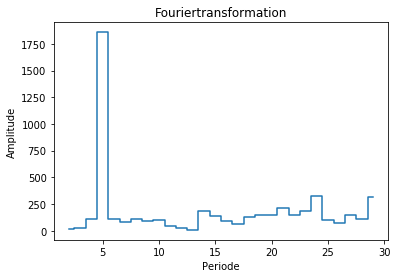

In [6]:
from math import tau, e

def fourier(x, k):
    return sum(x[n]*e**(-1j*tau*n/k) for n in range(0, len(x)))

transform = [abs(fourier(x, k)) for k in range(2,30)]

plt.step(list(range(2, 30)), transform, where='mid')
plt.xlabel("Periode")
plt.ylabel("Amplitude")
plt.title("Fouriertransformation")
plt.show()

Daraus wird ersichtlich, das unser Schlüssellängenkandidat $|\hat{K}|$ der folgende sein muss:
$ \arg \max |\mathcal{F}_x(\xi)| $

### Partitionierung
Im nächsten Schritt wollen wir das Chiffrat in $|\hat{K}|$ viele Partitionen unterteilen, deren Buchstaben Indizes im Modul $|\hat{K}|$ zur selben Restklasse gehören. Da alle Buchstaben einer Partition mit dem selben Schlüsselbuchstaben verschlüsselt wurden, lässt sich mittels einer Häufigkeitsanalyse der Schlüsselbuchstabe einer Partition erkennen. Dazu entschlüsseln wir jede Partition mit allen 26 möglichen Schlüsseln $K_i$ und vergleichen die Häufigkeitsanalyse des entschlüsselten Textes $f(Caesar_\hat{K_i}^{-1}(C))$ mit der erwarteten Buchstabenhäufigkeit im Deutschen $f(German)$ unter zur hilfenahme des Fehlerquadrats: 
$$MSE := (f(Caesar_\hat{K_i}^{-1}(C)) - f(German))^2$$
Das $\hat{K_i}$ mit der niedrigsten Abweichung für die i-te Partition ist unser Kandidat für den Schlüsselbuchstaben.

In [7]:
keylength = transform.index(max(transform)) + 2 # Verschiebung durch untere Intervalbegrenzung von 2

partitions = [ciphertext[i::keylength] for i in range(keylength)]

german = {'A': 0.0651, 'B': 0.0189, 'C': 0.0306, 'D': 0.0508, 'E': 0.174, 'F': 0.0166, 'G': 0.0301, 'H': 0.0476, 'I': 0.0755, 'J': 0.0027, 'K': 0.0121, 'L': 0.0344, 'M': 0.0253, 'N': 0.0978, 'O': 0.02501, 'P': 0.0079, 'Q': 0.0002, 'R': 0.07, 'S': 0.0727, 'T': 0.0615, 'U': 0.0435, 'V': 0.0067, 'W': 0.0189, 'X': 0.0003, 'Y': 0.0004, 'Z': 0.0113}
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def frequency_analysis(text):
    return {char: text.count(char)/len(text) for char in alphabet}

def caesar(plain, key):
    return "".join([alphabet[(alphabet.index(char)-alphabet.index(key)%26)] for char in plain])

def mean_squared_error(a,b):
    return sum((a[char]-b[char])**2 for char in alphabet)

def arg_min(x):
    return min(enumerate(x), key = lambda item: item[1])[0]

def min_deviation(text):
    return arg_min([mean_squared_error(german, frequency_analysis(caesar(text, char))) for char in alphabet])

key = "".join([alphabet[min_deviation(partition)] for partition in partitions])

print(key)

MATHE


### Entschlüsselung

Abschließend entschlüsseln wir das Chiffrat mit unserem Schlüsselkandidaten.

In [8]:
def vigenere(plain, key):
    return "".join([caesar(char, key[i%len(key)]) for i, char in enumerate(plain)])

plaintext = vigenere(ciphertext, key)

print(plaintext)

DIEKRYPTOLOGIELAESSTSICHAUCHINDIEBEIDENGEBIETEKRYPTOGRAPHIEMODERNERESCHREIBWEISEAUCHKRYPTOGRAFIEUNDKRYPTOANALYSEMODERNERESCHREIBWEISEAUCHKRYPTANALYSEUNTERTEILENDIESEEINTEILUNGENTWICKELTEDERRUSSISCHAMERIKANISCHEKRYPTOLOGEWILLIAMFRIEDMANENDEDESERSTENWELTKRIEGESVONIHMSTAMMENSOWOHLDIEBEGRIFFSDEFINITIONENWIEAUCHDIEABGRENZUNGUNTEREINANDERDEMFOLGENDBESCHAEFTIGTSICHDIEKRYPTOGRAPHIEMITDERENTWICKLUNGUNDANWENDUNGDEREINZELNENVERFAHRENUNDDIEKRYPTOANALYSEMITDERENSTAERKENUNDSCHWAECHENANDERSFORMULIERTBEFASSTSICHDIEKRYPTOGRAPHIEMITDERSICHERHEITDEREIGENENGEHEIMENKOMMUNIKATIONGEGENUNBEFUGTEENTZIFFERUNGODERVERAENDERUNGWAEHRENDDIEKRYPTOANALYSEQUASIALSGEGENSPIELERINDERKRYPTOGRAPHIEDASBRECHENDERSICHERHEITDERKOMMUNIKATIONZUMZIELHATKRYPTOGRAPHIEUNDKRYPTOANALYSEWERDENDAHERAUCHALSDEFENSIVEUNDOFFENSIVEKRYPTOLOGIEBEZEICHNET


`DIE KRYPTOLOGIE LAESST SICH AUCH IN DIE BEIDEN GEBIETE KRYPTOGRAPHIE MODERNERE SCHREIBWEISE AUCH KRYPTOGRAFIE UND KRYPTOANALYSE MODERNERE SCHREIBWEISE AUCH KRYPTANALYSE UNTERTEILEN DIESE EINTEILUNG ENTWICKELTE DER RUSSISCHAMERIKANISCHE KRYPTOLOGE WILLIAM FRIEDMAN ENDE DES ERSTEN WELT KRIEGES VON IHM STAMMEN SOWOHL DIE BEGRIFFSDEFINITIONEN WIE AUCH DIE ABGRENZUNG UNTER EINANDER DEM FOLGEND BESCHAEFTIGT SICH DIE KRYPTOGRAPHIE MIT DER ENTWICKLUNG UND ANWENDUNG DER EINZELNEN VERFAHREN UND DIE KRYPTOANALYSE MIT DEREN STAERKEN UND SCHWAECHEN ANDERS FORMULIERT BEFASST SICH DIE KRYPTOGRAPHIE MIT DER SICHERHEIT DER EIGENEN GEHEIMENKOMMUNIKATION GEGEN UNBEFUGTE ENTZIFFERUNG ODER VERAENDERUNG WAEHREND DIE KRYPTOANALYSE QUASI ALS GEGENSPIELER IN DER KRYPTOGRAPHIE DAS BRECHEN DER SICHERHEIT DERKOMMUNIKATION ZUM ZIEL HAT KRYPTOGRAPHIE UND KRYPTOANALYSE WERDEN DAHER AUCH ALS DEFENSIVE UND OFFENSIVE KRYPTOLOGIE BEZEICHNET`